In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms
import torchvision.datasets as dset
import torchvision.transforms as T

from torch.utils.data import DataLoader 
from torch.utils.data import sampler
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import os.path as osp
from PIL import Image
import pickle

from pytorch_load_data import load_data

plt.ion()   # interactive mode

In [2]:
batchsize=64
dataloaders, poster_train, poster_val, poster_test = load_data(batchsize=batchsize)
dataset_sizes = {}
dataset_sizes['train'] = len(dataloaders['train'])
dataset_sizes['val'] = len(dataloaders['val'])

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

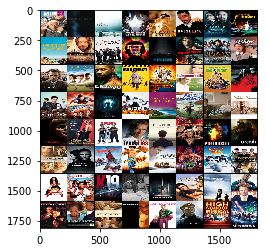

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
# print(' '.join('%5s' % labels[j] for j in range(BATCHSIZE)))

In [5]:
train_positives_count = 1601.0
train_negatives_count = 1744.0
val_positives_count = 461.0
val_negatives_count = 493.0

In [48]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
#                 scheduler.step()    # Update learning rate (decay)
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_corrects_positives = 0
            running_pred_positives = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        train_losses.append(loss)
                    elif phase == 'val':
                        val_losses.append(loss)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                print(torch.ones(batchsize, dtype=torch.float64, device=device) == preds.data.double())
                running_corrects_positives += torch.sum(preds.data == labels.data and preds.data == torch.ones(batchsize, dtype=torch.float64, device=device))
                running_pred_positives += torch.sum(preds.data.double() == torch.ones(batchsize, dtype=torch.float64, device=device))
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_precision, epoch_recall = 0, 0
            if phase == 'train':
                epoch_precision = running_corrects_positives.double() / running_pred_positives.double()
                epoch_recall = running_corrects_positives.double() / train_positives_count
                train_accuracies.append(epoch_acc)
            elif phase == 'val':
                epoch_precision = running_corrects_positives.double() / running_pred_positives.double()
                epoch_recall = running_corrects_positives.double() / val_positives_count
                val_accuracies.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            print('Precision: {:.4f}, Recall: {:.4f}'.format(
                epoch_precision, epoch_recall))
            time_elapsed = time.time() - since
            print('Time passes: {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [49]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [50]:
model_conv = torchvision.models.resnet18(pretrained=True)

# for param in model_conv.parameters():
#     param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.Adam(model_conv.parameters(), lr=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [51]:
learning_rates = [5e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
for learning_rate in learning_rates:
    print("learning_rate: {}".format(learning_rate))
    model_conv = torchvision.models.resnet18(pretrained=True)

    for param in model_conv.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, 2)

    model_conv = model_conv.to(device)

    criterion = nn.CrossEntropyLoss()

    exp_lr_scheduler = None
    optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=learning_rate, momentum=0.9)
    model_conv, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model_conv, criterion, optimizer_conv,
                             exp_lr_scheduler, num_epochs=1)
    
    print("learning_rate: {}".format(learning_rate))
    
    plt.subplot(311)
    plt.title('Training loss')
    plt.plot(train_losses, 'o')
    plt.xlabel('Iteration')

    plt.subplot(312)
    plt.title('Validation loss')
    plt.plot(val_losses, 'o')
    plt.xlabel('Iteration')
    
    plt.subplot(313)
    plt.title('Accuracy')
    plt.plot(train_accuracies, '-o', label='Train Accuracy')
    plt.plot(val_accuracies, '-o', label='Val Accuracy')
    plt.xlabel('Iteration')
    plt.legend(loc='lower center')
    
    plt.savefig('Transfer learning'+str(learning_rate)+'.pdf')
    
    with open(str(learning_rate)+'.pickle', 'wb') as file:
        pickle.dump((train_losses, val_losses, train_accuracy, val_accuracy), file, protocol=pickle.HIGHEST_PROTOCOL)

learning_rate: 5e-05
Epoch 0/0
----------
tensor([ 1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  0,  1,  1,  1,  0,  1,  1,  1,  1,  0,  1,
         1,  1,  1,  1,  1,  1,  0,  0,  1,  0,  1,  1,  1,  0,
         1,  1,  1,  1,  1,  1,  1,  1], dtype=torch.uint8, device='cuda:0')


RuntimeError: bool value of Tensor with more than one value is ambiguous

In [ ]:
# plt.subplot(311)
# plt.title('Training loss')
# plt.plot(train_losses, 'o')
# plt.xlabel('Iteration')

# plt.subplot(312)
# plt.title('Validation loss')
# plt.plot(val_losses, 'o')
# plt.xlabel('Iteration')

# plt.subplot(313)
# plt.title('Accuracy')
# plt.plot(train_accuracies, '-o', label='Train Accuracy')
# plt.plot(val_accuracies, '-o', label='Val Accuracy')
# plt.xlabel('Iteration')
# plt.legend(loc='lower center')

# plt.savefig('Transfer learning'+str(learning_rate)+'.pdf')

In [ ]:
# for i in range(2):
#     plt.subplot(311)
#     plt.title('Training loss')
#     plt.plot(train_losses, 'o')
#     plt.xlabel('Iteration')

#     plt.subplot(312)
#     plt.title('Validation loss')
#     plt.plot(val_losses, 'o')
#     plt.xlabel('Iteration')
    
#     plt.subplot(313)
#     plt.title('Amit loss')
#     plt.plot(val_losses, 'o')
#     plt.xlabel('Iteration')
    
#     plt.show()

In [ ]:
# lr = 1e-3
# with open(str(lr)+'.pickle', 'rb') as handle:
#     train_losses, val_losses = pickle.load(handle)

In [ ]:
# visualize_model(model_conv)

# plt.ioff()
# plt.show()

In [ ]:
# plt.subplot(1, 1, 1)
# plt.title('Training loss')
# plt.plot(train_losses, 'o')
# plt.xlabel('Iteration')

In [ ]:
# plt.subplot(1, 1, 1)
# plt.title('Validation loss')
# plt.plot(val_losses, 'o')
# plt.xlabel('Iteration')